# Домашнее задание 1
## Курс Машинное обучение
## Кацуба Кирилл, БПМ213

In [1]:
from collections import defaultdict
from math import log, prod
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Задание 1: Байесовская классификация

In [2]:
data = pd.read_csv('/Users/kirill/edu/3course/ML_MIEM/homeworks/names.csv')
data.sample(10)

,year,name,percent,sex
208602,1959,Marci,0.000130,girl
118692,1998,Tyrek,0.000120,boy
117659,1997,Jean,0.000125,boy
144016,1895,Alice,0.009943,girl
20810,1900,Gregorio,0.000068,boy
155665,1906,Enid,0.000096,girl
133230,1884,Myrtie,0.000509,girl
83984,1963,Bertram,0.000029,boy
253288,2004,Nancy,0.000567,girl
48134,1928,Tom,0.001140,boy


In [3]:
X = data.drop('sex', axis=1)
y = data.sex

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [5]:
def train(samples):
    """
    Тренируем датасет, считаем условные вероятности
    """
    classes, freq = defaultdict(lambda:0), defaultdict(lambda:0)
    for feats, label in samples:
        classes[label] += 1                 # count classes frequencies
        freq[label, feats] += 1          # count features frequencies

    for label, feat in freq:                # normalize features frequencies
        freq[label, feat] /= classes[label]
    for c in classes:                       # normalize classes frequencies
        classes[c] /= len(samples)
    return classes, freq, len(samples)                    # return P(C) and P(O|C)

def classify(classifier, name):
    """
    Этап классификации, классифицируем имена по полу
    используя наивный баесовский классификатор 
    (это немного усовершенстованный вариант, по сравнению с семинаром,
    так как мы добавляем смешение в сторону менее вероятных событий, тем самым
    вероятность классификации объекта, которого не было в тренировочном датасете 
    не нулевая)
    """
    classes, prob, n = classifier
    V_set = set()
    for key in prob.keys():
        V_set.add(key[1])
    V = len(V_set)
    return min(classes.keys(),              # calculate argmin(-log(P(C|O))) -> argmax(P(C|O))
        key = lambda cl: -log(classes[cl]) \
               + sum(-log(((prob.get((cl,feat), 0) * n * classes[cl]) + 1) \
                          / (V + (n * classes[cl]))) for feat in name))

def get_features(sample):
    return (sample[-1]) # get last letter

Сперва будем решать задачу по предсказанию пола человека по посленей букве имени (так мы делали на семинаре).

In [6]:
features = [(get_features(X_train.name.iloc[i]), y_train.iloc[i]) for i in range(len(X_train))]
classifier = train(features)
classifier

(defaultdict(<function __main__.train.<locals>.<lambda>()>,
             {'boy': 0.4997286821705426, 'girl': 0.5002713178294573}),
 defaultdict(<function __main__.train.<locals>.<lambda>()>,
             {('boy', 'g'): 0.005950072575373126,
              ('boy', 'o'): 0.06325691682086625,
              ('girl', 'n'): 0.08087527255420647,
              ('girl', 'a'): 0.38475245990547763,
              ('girl', 's'): 0.022324541500182624,
              ('girl', 'e'): 0.3004903208668607,
              ('girl', 'h'): 0.024438566005157775,
              ('girl', 'd'): 0.008179393241762499,
              ('girl', 'i'): 0.028157478223333962,
              ('boy', 'a'): 0.016287908167222524,
              ('boy', 'e'): 0.13833641732501578,
              ('boy', 'd'): 0.07260861375497224,
              ('girl', 'y'): 0.07844027050659111,
              ('boy', 'l'): 0.08209327320472903,
              ('boy', 'n'): 0.21594220562653046,
              ('boy', 's'): 0.0789464936676602,
             

В двух предыдущих ячейках мы посчитали вероятности того, что последня буква имени указывает на мужской или женский пол.

Теперь для каждого человека из тестовой выборки найдем пол.

In [7]:
gender_test = []
for row, item in X_test.iterrows():
    gender_test.append(classify(classifier, get_features(item[1])))
X_test['gender'] = gender_test
X_test.sample(20)

,year,name,percent,gender
64309,1944,Irvin,0.000277,boy
144531,1895,Ethyl,0.000125,boy
228294,1979,Raquel,0.000470,boy
17988,1897,Fitzhugh,0.000049,boy
229815,1980,Kacey,0.000110,boy
173346,1924,Merle,0.000296,girl
237863,1988,Giselle,0.000106,girl
199925,1950,Juliann,0.000053,boy
247465,1998,Deborah,0.000286,boy
255511,2006,Kiersten,0.000284,boy


Как видим точность предсказания по последней букве составила около 77.8%

In [8]:
accuracy_last_letter = np.mean(X_test['gender'] == y_test)
print(f"Средняя доля верных ответов: {accuracy_last_letter}")

Средняя доля верных ответов: 0.7783850129198966


Также в данном случае можно посторить $F_1$ меру. Для этого нужно посчитать полноту и точность, что позволит далее найти $F_1$ меру по формуле $F_1 = 2\frac{precision + recall}{precision * recall}$

In [9]:
print(f" F1 = {f1_score(y_test, X_test['gender'], average='macro')}")

 F1 = 0.7775146715624878


Стоит отметить, что сам алгоритм по определению пола по посленей букве не является достаточно точным, все зависит от обучающей выборик: число мужских/женских имен, количество различных последних букв и так далее.

Поэтому далее немного изменим подход к оцениванию пола человека. Брать имена целиком также не стоит, так как в датасете нет повторяющихся имен. Попробуем тогда брать первую букву в качестве оциниваемого признака.

Но заранее стоит отметить, что выбор суммы двух или более букв будет плохим варинтом, так как в этом случае вероятность встречи этих комбинаций будет длизка к нулю, таким образом вероятность того, что алгоритм правильно определит класс к которому будет относится новая пара букв из тестовой выборки крайне мала.

In [10]:
def get_features_new(sample):
    return sample[0].lower()

In [11]:
X = data.drop('sex', axis=1)
y = data.sex

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

features = [(get_features_new(X_train.name.iloc[i]), y_train.iloc[i]) for i in range(len(X_train))]
classifier_new = train(features)
classifier_new

(defaultdict(<function __main__.train.<locals>.<lambda>()>,
             {'boy': 0.4997286821705426, 'girl': 0.5002713178294573}),
 defaultdict(<function __main__.train.<locals>.<lambda>()>,
             {('boy', 's'): 0.04880832345347974,
              ('boy', 'i'): 0.015988742507008234,
              ('girl', 'r'): 0.04929772327308548,
              ('girl', 'j'): 0.07147837828863629,
              ('girl', 'o'): 0.01390164805365859,
              ('girl', 'i'): 0.01987847126144174,
              ('girl', 'f'): 0.02178220013503193,
              ('girl', 'k'): 0.04593299317092608,
              ('girl', 'd'): 0.05269565794862146,
              ('girl', 'l'): 0.09083664456717838,
              ('girl', 'c'): 0.08326600183731973,
              ('boy', 'a'): 0.08235919823603062,
              ('girl', 'v'): 0.026154135629614054,
              ('girl', 's'): 0.05736643460359273,
              ('girl', 'e'): 0.06665264695790767,
              ('boy', 'h'): 0.03994415574342666,
           

In [12]:
gender_test_new = []
for row, item in X_test.iterrows():
    gender_test_new.append(classify(classifier_new, get_features_new(item[1])))
X_test['gender'] = gender_test_new
X_test.sample(20)

,year,name,percent,gender
163744,1914,Verdie,0.000075,girl
57911,1937,Eloy,0.000043,girl
98967,1978,Amanda,0.000046,girl
136598,1887,Huldah,0.000097,boy
242917,1993,Porsha,0.000106,girl
69902,1949,Antone,0.000032,girl
209949,1960,Kerrie,0.000061,girl
181018,1932,Frances,0.008636,boy
100485,1980,Jim,0.000163,boy
211750,1962,Staci,0.000094,girl


In [13]:
accuracy_first_letter = np.mean(X_test['gender'] == y_test)
print(f"Средняя доля верных ответов: {accuracy_first_letter}")
print(f" F1 = {f1_score(y_test, X_test['gender'], average='macro')}")

Средняя доля верных ответов: 0.5717054263565892
 F1 = 0.5693269241676946


В качестве примера, построим такой же алгоритм для суммы двух букв (предпоследняя + последняя)

In [14]:
def get_features_new(sample):
    return sample[-2:].lower()

X = data.drop('sex', axis=1)
y = data.sex

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

features = [(get_features_new(X_train.name.iloc[i]), y_train.iloc[i]) for i in range(len(X_train))]
classifier_new = train(features)

gender_test_new = []
for row, item in X_test.iterrows():
    gender_test_new.append(classify(classifier_new, get_features_new(item[1])))
X_test['gender'] = gender_test_new

accuracy_sum_letter = np.mean(X_test['gender'] == y_test)
print(f"Средняя доля верных ответов: {accuracy_sum_letter}")
print(f" F1 = {f1_score(y_test, X_test['gender'], average='macro')}")

Средняя доля верных ответов: 0.5006330749354005
 F1 = 0.3336145812706093


Отсюда можем сделать вывод, что это наихудший вариант, так как в этом случае алгоритм угадал очень мало имен либо жеснкого, либо мужского пола. Это произошло из-за низкой веротяности встретить пару букв в каждом из классов.

## Модифицируем метод classify()

In [15]:
def train(samples):
    """
    Тренируем датасет, считаем условные вероятности
    """
    classes, freq = defaultdict(lambda:0), defaultdict(lambda:0)
    for feats, label in samples:
        classes[label] += 1                 
        freq[label, feats] += 1          

    for label, feat in freq:                
        freq[label, feat] /= classes[label]
    for c in classes:                       
        classes[c] /= len(samples)
    return classes, freq, len(samples)                    

def classify_simple(classifier, name):
    """
    Максимизируем произведение вероятностей. Функционал такой же как и 
    у classify().
    """
    classes, prob, n = classifier
    V_set = set()
    for key in prob.keys():
        V_set.add(key[1])
    V = len(V_set)
    return max(classes.keys(),              
        key = lambda cl: classes[cl] 
               * prod(((prob.get((cl,feat), 0) * n * classes[cl]) + 1) \
                          / (V + (n * classes[cl])) for feat in name))

Повторим самый первый пример

In [16]:
def get_features(sample):
    return (sample[-1]) # get last letter

X = data.drop('sex', axis=1)
y = data.sex

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

features = [(get_features(X_train.name.iloc[i]), y_train.iloc[i]) for i in range(len(X_train))]
classifier = train(features)

gender_test = []
for row, item in X_test.iterrows():
    gender_test.append(classify_simple(classifier, get_features(item[1])))
X_test['gender'] = gender_test

accuracy_simple_class = np.mean(X_test['gender'] == y_test)
print(f"Средняя доля верных ответов: {accuracy_simple_class}, совпала ли метрика с первым результатом: {accuracy_simple_class == accuracy_last_letter}")
print(f" F1 = {f1_score(y_test, X_test['gender'], average='macro')}")

Средняя доля верных ответов: 0.7783850129198966, совпала ли метрика с первым результатом: True
 F1 = 0.7775146715624878


Как видим результаты самого первого и данного тестов совпали, так и должно быть, ведь все преобразования которые приводят из певрого случая во второй эвиваленты. Это достаточно легко показать:

$ -ln(P(C)) -\sum\limits_{O\in Object} ln(P(C|O)) \rightarrow argmin_{c \in Classes} \implies ln(P(C)) + \sum\limits_{O\in Object} ln(P(C|O)) \rightarrow argmax_{c \in Classes} \implies$ (потенцируем) $ P(C) * \Pi_{O\in Object} P(C|O) \rightarrow argmax_{c \in Classes}$ 

Теперь воспользуемся гауссовским и мультиномиальным классификатором (методы из sklearn.naive_bayes). И сравним результаты.

С помощью one-hot кодироваяния заменим категориальные признаки на вектора состоящие из 0 и 1.

In [17]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import OneHotEncoder
data['last_letter'] = np.array([get_features(data.name.iloc[i]) for i in range(data.shape[0])])
X = data[['sex', 'last_letter']]
y = data[['sex']]
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X[['sex', 'last_letter']])
X_ohe = enc.transform(X[['sex', 'last_letter']]).toarray()
X_ohe

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [18]:
one_hot_encoded_data = pd.get_dummies(data, columns = ['sex', 'last_letter']) 
one_hot_encoded_data

,year,name,percent,sex_boy,sex_girl,last_letter_a,last_letter_b,last_letter_c,last_letter_d,last_letter_e,...,last_letter_q,last_letter_r,last_letter_s,last_letter_t,last_letter_u,last_letter_v,last_letter_w,last_letter_x,last_letter_y,last_letter_z
0,1880,John,0.081541,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1880,William,0.080511,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1880,James,0.050057,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1880,Charles,0.045167,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1880,George,0.043292,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257995,2008,Carleigh,0.000128,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
257996,2008,Iyana,0.000128,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
257997,2008,Kenley,0.000127,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
257998,2008,Sloane,0.000127,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [19]:
X = one_hot_encoded_data.drop(['year', 'name', 'percent', 'sex_boy', 'sex_girl'], axis=1)
y = one_hot_encoded_data.sex_boy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
model = GaussianNB().fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Гауссовский классификатор из sklearn показал следующие результаты: ')
print(f'Средняя доля верных ответов: {np.mean(y_pred == y_test)}')
print(f" F1 = {f1_score(y_test, y_pred, average='macro')}")

Гауссовский классификатор из sklearn показал следующие результаты: 
Средняя доля верных ответов: 0.5968087855297157
 F1 = 0.5272850685057378


In [20]:
model = MultinomialNB().fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_GaussianNB = np.mean(y_pred == y_test)
print('Мультиномиальный классификатор из sklearn показал следующие результаты: ')
print(f'Средняя доля верных ответов: {np.mean(y_pred == y_test)}')
print(f" F1 = {f1_score(y_test, y_pred, average='macro')}")

Мультиномиальный классификатор из sklearn показал следующие результаты: 
Средняя доля верных ответов: 0.7783850129198966
 F1 = 0.7775146715624878


Как видим наиболее эффективным оказались мультиномиальный и наивный баесовский классификаторы. Оба метода показали среднюю долю угаданных ответов в 77.8%

# Задание 2: Классификация ирисов

In [21]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [22]:
# теперь используем LDA из sklearn, чтобы классифицировать ирисы по классам, 
# применяя кроссвалидацию
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"Средняя доля верных ответов: {np.mean(y_pred == y_test)}")
print(f" F1 = {f1_score(y_test, y_pred, average='macro')}")

Средняя доля верных ответов: 1.0
 F1 = 1.0


Как видим модель определяет сорт ириса с очень высокой точностью, тогда для более правильного результата обратимся к кроссвалидации для того, чтобы лучше понимать как ведет себя построенная модель.

In [23]:
scores = cross_val_score(clf, X, y, cv=4)
print(f"С помощью кроссвалидации была получена следующая точность: {np.mean(scores)}")

С помощью кроссвалидации была получена следующая точность: 0.9799075391180655


Теперь обратимся к функции LDA_dimensionality(), написанной на семинаре. С ее помощью мы искали матрицу, которую преобразовывала исходную систему координат (в задаче с ирисами мы находимся к 4-ех мерном прострастве) так, чтобы уменьшалась размерность пространства и мы могли легче классифицировать ирисы.

In [24]:
# функция по уменьшению размерности написанная на семинаре
def LDA_dimensionality(X, y, k):
    '''
    X - набор данных, y - метка, k - целевой размер
    '''
    label_ = list(set(y))

    X_classify = {}

    for label in label_:
        X1 = np.array([X[i] for i in range(len(X)) if y[i] == label])
        X_classify[label] = X1

    mju = np.mean(X, axis=0)
    mju_classify = {}

    for label in label_:
        mju1 = np.mean(X_classify[label], axis=0)
        mju_classify[label] = mju1

    Sw = np.zeros((len(mju), len(mju)))  # Вычислить матрицу внутриклассовой дивергенции
    for i in label_:
        Sw += np.dot((X_classify[i] - mju_classify[i]).T,
                     X_classify[i] - mju_classify[i])

    Sb = np.zeros((len(mju), len(mju)))  # Вычислить матрицу внутриклассовой дивергенции
    for i in label_:
        Sb += len(X_classify[i]) * np.dot((mju_classify[i] - mju).reshape(
            (len(mju), 1)), (mju_classify[i] - mju).reshape((1, len(mju))))

    eig_vals, eig_vecs = np.linalg.eig(
        np.linalg.inv(Sw).dot(Sb))  # Вычислить собственное значение и собственную матрицу Sw-1 * Sb

    sorted_indices = np.argsort(eig_vals)
    topk_eig_vecs = eig_vecs[:, sorted_indices[:-k - 1:-1]]  # Извлекаем первые k векторов признаков
    return topk_eig_vecs

Пример работы функции

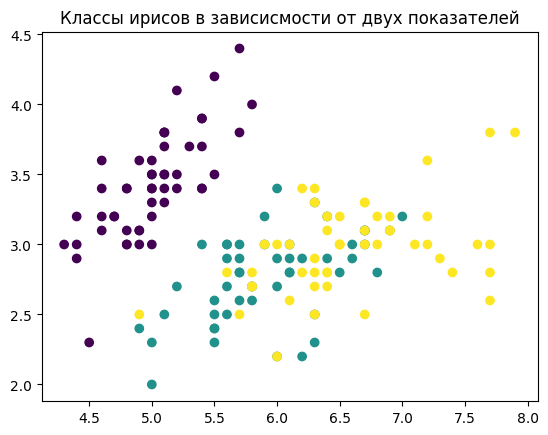

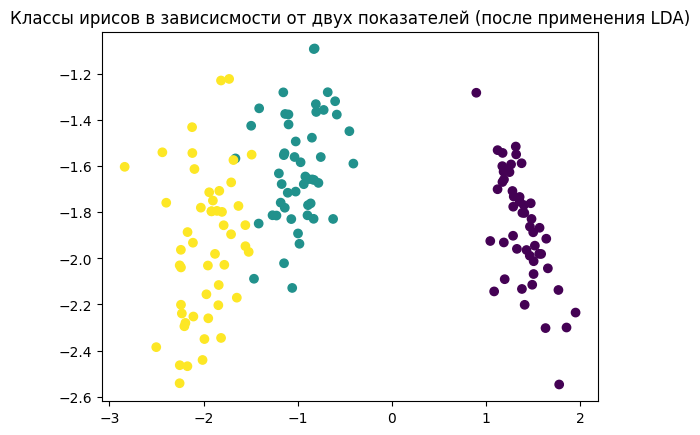

In [25]:
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)
plt.title("Классы ирисов в зависисмости от двух показателей")
plt.show()

W = LDA_dimensionality(X, y, 2)
X_new = np.dot((X), W)
plt.scatter(X_new[:, 0], X_new[:, 1], marker='o', c=y)
plt.title("Классы ирисов в зависисмости от двух показателей (после применения LDA)")
plt.show()

Получаем, два графика, показывающие как работает LDA. Мы уменьшили размерность, тем самым разбили все типы ириса по кслассам. 

Далее воспользуемся любым классификатором (например встроенным в sklearn kNN) чтобы разбить выборку (с уменьшенной размерностью) на классы и сравним полученные результаты.

In [26]:
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=10)
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"Средняя доля верных ответов: {np.mean(y_pred == y_test)}")
print(f" F1 = {f1_score(y_test, y_pred, average='macro')}")

Средняя доля верных ответов: 0.9777777777777777
 F1 = 0.9784047370254267


Как видим предсказание с помощью kNN сорта ириса на уменьшенной размерности имеет схожую, со встроенным в sklearn LDA, точность полученную на кроссвалидации.

In [27]:
clf = LinearDiscriminantAnalysis()
scores = cross_val_score(clf, X_new, y, cv=4)
print(f"С помощью кроссвалидации была получена следующая точность: {np.mean(scores)}")

С помощью кроссвалидации была получена следующая точность: 0.9799075391180655


Как видим на уменьшенной размерности результаты LDA на кроссвалидации совпали с результатами LDA для полной задачи.

Теперь с помощью метода transform() преобразуем матрицу исходных признаков и постороим график.

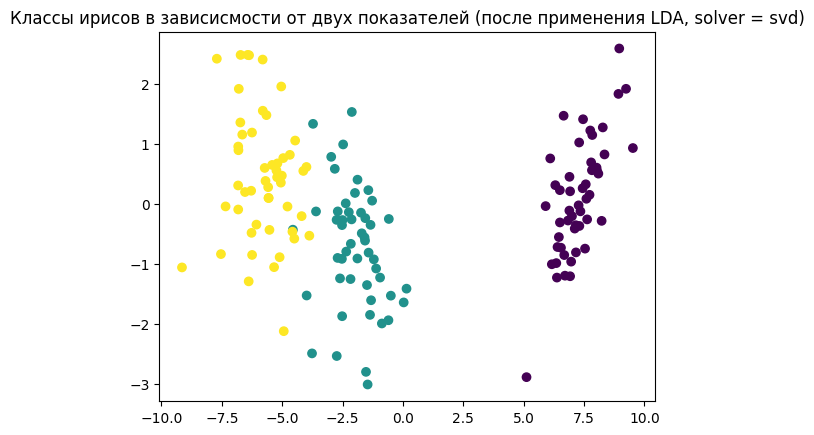

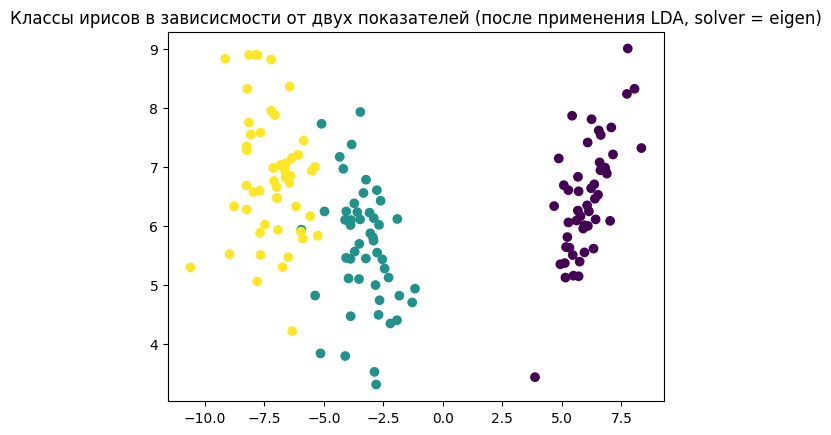

In [28]:
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

clf = LinearDiscriminantAnalysis(solver='svd')
clf.fit(X_train, y_train)
X_lda = clf.transform(X)
plt.scatter(X_lda[:, 0], X_lda[:, 1], marker='o', c=y)
plt.title("Классы ирисов в зависисмости от двух показателей (после применения LDA, solver = svd)")
plt.show()

clf = LinearDiscriminantAnalysis(solver='eigen')
clf.fit(X_train, y_train)
X_lda = clf.transform(X)
plt.scatter(X_lda[:, 0], X_lda[:, 1], marker='o', c=y)
plt.title("Классы ирисов в зависисмости от двух показателей (после применения LDA, solver = eigen)")
plt.show()

Графики полученные с помощью LDA из sklearn немного отличаются от преобразования, полученного на семинаре, но стоит отметить, что они очень схожи, во всех случаях заметно четкое разбиение на классы.

Теперь обратимся к доументации, бдуем менять аргументы классификатора LDA. Проследим какой из них будет лучше/хуже сказываться на предсказаниях модели.

Будем менять один параметр: solver. Остальные параметры по умолчанию стоят None или False, единтсвенный числовой паремтр tol = 1e-4. Данные параметры либо подбираются автоматически по обучающей выборке (n_components, priors). Оставшиеся 3 параметра должны выставляться в зависимости от метода solver или shrinkage. Поэтому подбор параметров будет происходить только для solver.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

solver_list = ['svd', 'lsqr', 'eigen']
for solver in solver_list:
    clf = LinearDiscriminantAnalysis(solver=solver)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f'solver = {solver}: ')
    print(f"Mean: {np.mean(y_pred == y_test)}")
    print(f" F1 = {f1_score(y_test, y_pred, average='macro')}\n")

solver = svd: 
Mean: 1.0
 F1 = 1.0

solver = lsqr: 
Mean: 1.0
 F1 = 1.0

solver = eigen: 
Mean: 1.0
 F1 = 1.0



Теперь проверим, как работает классификатор на разных параметрах при кроссвалидации.

In [30]:
solver_list = ['svd', 'lsqr', 'eigen']
for solver in solver_list:
    clf = LinearDiscriminantAnalysis(solver=solver)
    scores = cross_val_score(clf, X, y, cv=4)
    print(f'solver = {solver}: ')
    print(f"CV: {np.mean(scores)}\n")

solver = svd: 
CV: 0.9799075391180655

solver = lsqr: 
CV: 0.9799075391180655

solver = eigen: 
CV: 0.9799075391180655



Стоит отметить, что построенные графики, показывающие преобразованный вектор признаков, отражают, что во многом работа классификатора на разных параметров solver должны быть одинаковыми.

Например, на графиках видно, что значения на абсциссе и ординате могут быть различными, но тем не менее разбиение на классы одинаково.

Скорее всего из-за относительно небольшой размерности задачи изменение параметров не дало значительных изменений в задаче. Различия состоят в преобразовании признаков (разные значения на абсциссе и ординате). В остальном разделение на классы такое же.

# Задание 3: kNN

In [31]:
from sklearn.datasets import load_wine
from sklearn.model_selection import StratifiedKFold, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score
wine = load_wine()
X = wine.data
y = wine.target
X

array([[1.423e+01, 1.710e+00, 2.430e+00, ..., 1.040e+00, 3.920e+00,
        1.065e+03],
       [1.320e+01, 1.780e+00, 2.140e+00, ..., 1.050e+00, 3.400e+00,
        1.050e+03],
       [1.316e+01, 2.360e+00, 2.670e+00, ..., 1.030e+00, 3.170e+00,
        1.185e+03],
       ...,
       [1.327e+01, 4.280e+00, 2.260e+00, ..., 5.900e-01, 1.560e+00,
        8.350e+02],
       [1.317e+01, 2.590e+00, 2.370e+00, ..., 6.000e-01, 1.620e+00,
        8.400e+02],
       [1.413e+01, 4.100e+00, 2.740e+00, ..., 6.100e-01, 1.600e+00,
        5.600e+02]])

# KFold 

In [32]:
kfold_list = []
kfold_cv = KFold(n_splits=5, random_state=42, shuffle=True)
for k in range(1, 51):
    model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(model, X, y, cv=kfold_cv)
    kfold_list.append(np.mean(scores))
print(f'Наилучшая точность кроссвалидации Kfold при k = {np.argmax(kfold_list) + 1}, accuracy = {np.max(kfold_list)}')

Наилучшая точность кроссвалидации Kfold при k = 1, accuracy = 0.7304761904761905


In [33]:
kfold_list = []
kfold_cv = KFold(n_splits=5, random_state=42, shuffle=True)
for k in range(1, 51):
    correct = 0
    total = 0
    arr_ans = []
    for train_indices, test_indices in kfold_cv.split(X):
        X_train, X_test, y_train, y_test = X[train_indices], X[test_indices], \
                                            y[train_indices], y[test_indices]
        model = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
        y_pred = model.predict(X_test)
        arr_ans.append(np.mean(y_pred == y_test))
    kfold_list.append(np.mean(arr_ans))
print(f'Наилучшая точность кроссвалидации Kfold при k = {np.argmax(kfold_list) + 1}, accuracy = {np.max(kfold_list)}')

Наилучшая точность кроссвалидации Kfold при k = 1, accuracy = 0.7304761904761905


# Leave One Out

In [34]:
loocv_list = []
loocv = LeaveOneOut()
for k in range(1, 51):
    model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(model, X, y, cv=loocv)
    loocv_list.append(np.mean(scores))
print(f'Наилучшая точность кроссвалидации LeaveOneOut при k = {np.argmax(loocv_list) + 1}, accuracy = {np.max(loocv_list)}')

Наилучшая точность кроссвалидации LeaveOneOut при k = 1, accuracy = 0.7696629213483146


In [47]:
loocv_list = []
loocv = LeaveOneOut()
for k in range(1, 51):
    correct = 0
    total = 0
    arr_ans = []
    for train_indices, test_indices in loocv.split(X):
        X_train, X_test, y_train, y_test = X[train_indices], X[test_indices], \
                                            y[train_indices], y[test_indices]
        model = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
        y_pred = model.predict(X_test)
        arr_ans.append(np.mean(y_pred == y_test))
    loocv_list.append(np.mean(arr_ans))
print(f'Наилучшая точность кроссвалидации LeaveOneOut при k = {np.argmax(loocv_list) + 1}, accuracy = {np.max(loocv_list)}')

Наилучшая точность кроссвалидации LeaveOneOut при k = 1, accuracy = 0.7696629213483146


# Stratified KFold

In [36]:
strKfold_list = []
strKfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for k in range(1, 51):
    model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(model, X, y, cv=strKfold)
    strKfold_list.append(np.mean(scores))
print(f'Наилучшая точность кроссвалидации StratifiedKFold при k = {np.argmax(strKfold_list) + 1}, accuracy = {np.max(strKfold_list)}')

Наилучшая точность кроссвалидации StratifiedKFold при k = 1, accuracy = 0.7185714285714285


In [37]:
strKfold_list = []
strKfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for k in range(1, 51):
    correct = 0
    total = 0
    arr_ans = []
    for train_indices, test_indices in strKfold.split(X, y):
        X_train, X_test, y_train, y_test = X[train_indices], X[test_indices], \
                                            y[train_indices], y[test_indices]
        model = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
        y_pred = model.predict(X_test)
        arr_ans.append(np.mean(y_pred == y_test))
    strKfold_list.append(np.mean(arr_ans))
print(f'Наилучшая точность кроссвалидации StratifiedKFold при k = {np.argmax(strKfold_list) + 1}, accuracy = {np.max(strKfold_list)}')

Наилучшая точность кроссвалидации StratifiedKFold при k = 1, accuracy = 0.7185714285714285


Мы посчитали точность для каждой кроссвалидации двумя разными способами, видим что они совпали.

Наилучший результат достигается при кроссвалидации Leave One Out для классификатора kNN при k = 1.

Произведем масштабирование, посмотрим что изменится в этом случае

In [38]:
from sklearn.preprocessing import StandardScaler
X_scale = StandardScaler().fit_transform(X)
X_scale

array([[ 1.51861254, -0.5622498 ,  0.23205254, ...,  0.36217728,
         1.84791957,  1.01300893],
       [ 0.24628963, -0.49941338, -0.82799632, ...,  0.40605066,
         1.1134493 ,  0.96524152],
       [ 0.19687903,  0.02123125,  1.10933436, ...,  0.31830389,
         0.78858745,  1.39514818],
       ...,
       [ 0.33275817,  1.74474449, -0.38935541, ..., -1.61212515,
        -1.48544548,  0.28057537],
       [ 0.20923168,  0.22769377,  0.01273209, ..., -1.56825176,
        -1.40069891,  0.29649784],
       [ 1.39508604,  1.58316512,  1.36520822, ..., -1.52437837,
        -1.42894777, -0.59516041]])

# KFold, StandardScaler

In [39]:
kfold_list = []
kfold_cv = KFold(n_splits=5, random_state=42, shuffle=True)
for k in range(1, 51):
    model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(model, X_scale, y, cv=kfold_cv)
    kfold_list.append(np.mean(scores))
print(f'Наилучшая точность кроссвалидации Kfold при k = {np.argmax(kfold_list) + 1}, accuracy = {np.max(kfold_list)}')

Наилучшая точность кроссвалидации Kfold при k = 29, accuracy = 0.9776190476190475


In [40]:
kfold_list = []
kfold_cv = KFold(n_splits=5, random_state=42, shuffle=True)
for k in range(1, 51):
    correct = 0
    total = 0
    arr_ans = []
    for train_indices, test_indices in kfold_cv.split(X):
        X_train, X_test, y_train, y_test = X_scale[train_indices], X_scale[test_indices], \
                                            y[train_indices], y[test_indices]
        model = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
        y_pred = model.predict(X_test)
        arr_ans.append(np.mean(y_pred == y_test))
    kfold_list.append(np.mean(arr_ans))
print(f'Наилучшая точность кроссвалидации Kfold при k = {np.argmax(kfold_list) + 1}, accuracy = {np.max(kfold_list)}')

Наилучшая точность кроссвалидации Kfold при k = 29, accuracy = 0.9776190476190475


# Leave One Out, StandardScaler

In [41]:
loocv_list = []
loocv = LeaveOneOut()
for k in range(1, 51):
    model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(model, X_scale, y, cv=loocv)
    loocv_list.append(np.mean(scores))
print(f'Наилучшая точность кроссвалидации LeaveOneOut при k = {np.argmax(loocv_list) + 1}, accuracy = {np.max(loocv_list)}')

Наилучшая точность кроссвалидации LeaveOneOut при k = 36, accuracy = 0.9831460674157303


In [42]:
loocv_list = []
loocv = LeaveOneOut()
for k in range(1, 51):
    correct = 0
    total = 0
    arr_ans = []
    for train_indices, test_indices in loocv.split(X):
        X_train, X_test, y_train, y_test = X_scale[train_indices], X_scale[test_indices], \
                                            y[train_indices], y[test_indices]
        model = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
        y_pred = model.predict(X_test)
        arr_ans.append(np.mean(y_pred == y_test))
    loocv_list.append(np.mean(arr_ans))
print(f'Наилучшая точность кроссвалидации LeaveOneOut при k = {np.argmax(loocv_list) + 1}, accuracy = {np.max(loocv_list)}')

Наилучшая точность кроссвалидации LeaveOneOut при k = 36, accuracy = 0.9831460674157303


# Stratified KFold, StandardScaler

In [43]:
strKfold_list = []
strKfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for k in range(1, 51):
    model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(model, X_scale, y, cv=strKfold)
    strKfold_list.append(np.mean(scores))
print(f'Наилучшая точность кроссвалидации StratifiedKFold при k = {np.argmax(strKfold_list) + 1}, accuracy = {np.max(strKfold_list)}')

Наилучшая точность кроссвалидации StratifiedKFold при k = 13, accuracy = 0.9776190476190475


In [44]:
strKfold_list = []
strKfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for k in range(1, 51):
    correct = 0
    total = 0
    arr_ans = []
    for train_indices, test_indices in strKfold.split(X, y):
        X_train, X_test, y_train, y_test = X_scale[train_indices], X_scale[test_indices], \
                                            y[train_indices], y[test_indices]
        model = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
        y_pred = model.predict(X_test)
        arr_ans.append(np.mean(y_pred == y_test))
    strKfold_list.append(np.mean(arr_ans))
print(f'Наилучшая точность кроссвалидации StratifiedKFold при k = {np.argmax(strKfold_list) + 1}, accuracy = {np.max(strKfold_list)}')

Наилучшая точность кроссвалидации StratifiedKFold при k = 13, accuracy = 0.9776190476190475


In [45]:
print(np.min(X_scale), np.max(X_scale))
print(np.min(X), np.max(X))

-3.6791622340370145 4.371372139554767
0.13 1680.0


После масштабирования признаки лежат в интервале \[-3.68, 4.38\], до масштабирования - \[0.13, 1680\].
Таким образом мы уменьшили разброс признаков - свели признаки к одному диапозону. Этот шаг был очень важен, так как в kNN необходимо учитывать расстояние между объектами, а изначальные значения признаков сильно искажали модель, поэтому мы и получили более плохие результаты в первом случае.

Во втором случае на каждой из кроссвалидаций модель показала более 97% точности. Наилучший показатель демонстрируется на кроссвалидации Leave One Out при k = 36, accuracy = 0.98.

При этом заметим, что оптимальный метод валидации не изменился, но параметр k в kNN увеличился на 35.